In [9]:
# SETUP PARAMETERS
# db_addr='128.199.166.149'
db_addr='172.16.101.172'
# db_addr='localhost'
db_port=27340
db_user_email = 'demo@example.com'
filename_ics = "DEMO_TASK_HISTORY_1114.ics"



In [10]:
# Access DB. Find user ID for the google ics file.

from pymongo import MongoClient

client = MongoClient(db_addr, db_port)
# print client.database_names()
db = client.test
# print db.collection_names()

myaccount = db.accounts.find_one({'email': db_user_email})
userID = myaccount['_id']
print userID


5646f430240054917859503d


In [12]:
import tokenizer
import json

def tzChange(t, tz_from='UTC', tz_to='Asia/Seoul'):
    from datetime import datetime
    from dateutil import tz
    
    from_zone = tz.gettz(tz_from)
    to_zone = tz.gettz(tz_to)
    # Tell the datetime object 't'.
    # datetime objects are 'naive' by default
    t = t.replace(tzinfo=from_zone)

    # Convert time zone
    local = t.astimezone(to_zone)
    return local

def getTimeIndex336(t):
    '''
    t is python datetime object
    '''
    
    # Sunday:0, Saturday:6
    return (t.weekday()+1)%7 * 48 + t.hour * 2 + t.minute/30

def getTimeIndex48(t):
    '''
    t is python datetime object
    '''
    # Sunday:0, Saturday:6
    return t.hour * 2 + t.minute/30


CONST_GOOGLECAL_TOKEN_TYPE = 9999

def createPredTokenFromGCal(userID, text, daytime=-1, weekday=-1):
    import datetime
    objdict = {};
    objdict['loc'] = {'type': 'Point', 'coordinates': [127.04512999999999, 37.5040797]} # u'loc': {u'type': u'Point', u'coordinates': [127.04512999999999, 37.5040797]}
    objdict['text'] = text
    objdict['userId'] = userID
    
    # Only one filed has meaningful value and the others have value -1.
    objdict['daytime'] = daytime # getTimeIndex48(time)
    objdict['weekday'] = weekday # (time.weekday()+1)%7
    
    objdict['prevType'] = 0 # Dummy
    objdict['__v'] = 0 # Dummy
    objdict['taskId'] = None # ObjectId('562a0c5441121d2d907405ec')
    objdict['duration'] = datetime.datetime(1970, 1, 2, 0, 0) # Dummy
    objdict['type'] = CONST_GOOGLECAL_TOKEN_TYPE
    
    return objdict


import vobject
data = open(filename_ics).read()
cal = vobject.readOne(data)

predtokens = []
tasklogs = []
print 'Number of tasks: ', len(cal.vevent_list)
for event in cal.vevent_list:
    print 'Summary: ', event.summary.value
    print 'Description: ', event.description.value
    tokens = tokenizer.permute(tokenizer.extractor(event.summary.value + ' ' + event.description.value))
    print 'Tokens: ', json.dumps(tokens, ensure_ascii=False)

    # Get Time
    stTime = tzChange(event.dtstart.value)
    enTime = tzChange(event.dtend.value)
    
    stIdx = getTimeIndex336(stTime)
    enIdx = getTimeIndex336(enTime)
    
    print 'Time (as a datetime object): ', stTime
    print 'startTimeIndex: ', stIdx
    print 'Time (as a datetime object): ', enTime
    print 'endTimeIndex: ', enIdx
    
    # Generate TaskLog
    
    
    # Assume that one event doen not span over more than one week.
    # Make token for every timeslot, and weekday. 
    for token in tokens:
        visit_check = [0] * 7;
        
        for index_timeslot in range(stIdx, enIdx+1):
            if visit_check[index_timeslot/48] == 0:
                visit_check[index_timeslot/48] = 1;
                predtokens.append(createPredTokenFromGCal(userID, token, weekday=index_timeslot/48))
            predtokens.append(createPredTokenFromGCal(userID, token, daytime=index_timeslot%48))
    


Number of tasks:  179
Summary:  연구실 회식
Description:  
Tokens:  ["연구실", "회식", "연구실+회식"]
Time (as a datetime object):  2015-11-09 18:00:00+09:00
startTimeIndex:  84
Time (as a datetime object):  2015-11-09 21:00:00+09:00
endTimeIndex:  90
Summary:  독서
Description:  
Tokens:  ["독서"]
Time (as a datetime object):  2015-11-07 19:30:00+09:00
startTimeIndex:  327
Time (as a datetime object):  2015-11-07 20:30:00+09:00
endTimeIndex:  329
Summary:  시간 관련된 토큰 프리셋 처리
Description:  
Tokens:  ["시간", "관련", "토큰", "프리", "처리", "시간+관련", "시간+토큰", "시간+프리", "시간+처리", "관련+토큰", "관련+프리", "관련+처리", "토큰+프리", "토큰+처리", "프리+처리", "시간+관련+토큰", "시간+관련+프리", "시간+관련+처리", "시간+토큰+프리", "시간+토큰+처리", "시간+프리+처리", "관련+토큰+프리", "관련+토큰+처리", "관련+프리+처리", "토큰+프리+처리"]
Time (as a datetime object):  2015-11-13 23:00:00+09:00
startTimeIndex:  286
Time (as a datetime object):  2015-11-14 00:00:00+09:00
endTimeIndex:  288
Summary:  소마 완성도 향상
Description:  
Tokens:  ["소마", "완성", "향상", "소마+완성", "소마+향상", "완성+향상", "소마+완성+향상"]
Time (as a datetime o

TypeError: 'tzinfo' is an invalid keyword argument for this function

In [13]:
print 'Number of predTokens: ', len(predtokens)
for t in predtokens[0:10]:
    print t

Number of predTokens:  17733
{'loc': {'type': 'Point', 'coordinates': [127.04512999999999, 37.5040797]}, 'text': '\xec\x97\xb0\xea\xb5\xac\xec\x8b\xa4', 'userId': ObjectId('5646f430240054917859503d'), 'daytime': -1, 'prevType': 0, '__v': 0, 'weekday': 1, 'taskId': None, 'duration': datetime.datetime(1970, 1, 2, 0, 0), 'type': 9999}
{'loc': {'type': 'Point', 'coordinates': [127.04512999999999, 37.5040797]}, 'text': '\xec\x97\xb0\xea\xb5\xac\xec\x8b\xa4', 'userId': ObjectId('5646f430240054917859503d'), 'daytime': 36, 'prevType': 0, '__v': 0, 'weekday': -1, 'taskId': None, 'duration': datetime.datetime(1970, 1, 2, 0, 0), 'type': 9999}
{'loc': {'type': 'Point', 'coordinates': [127.04512999999999, 37.5040797]}, 'text': '\xec\x97\xb0\xea\xb5\xac\xec\x8b\xa4', 'userId': ObjectId('5646f430240054917859503d'), 'daytime': 37, 'prevType': 0, '__v': 0, 'weekday': -1, 'taskId': None, 'duration': datetime.datetime(1970, 1, 2, 0, 0), 'type': 9999}
{'loc': {'type': 'Point', 'coordinates': [127.04512999

In [14]:
token_collection = db.predicttokens;
token_collection.remove({'userId': userID})

for t in predtokens:    
    token_collection.insert_one(t)
    
num =0
for t in token_collection.find():
    print t
    num +=1
    if num == 10:
        break
    



{u'loc': {u'type': u'Point', u'coordinates': [127.04512999999999, 37.5040797]}, u'text': u'\uc1fc\ud551+\uc637+\uc0ac\uae30', u'userId': ObjectId('5646f430240054917859503d'), u'daytime': 29, u'prevType': 0, u'__v': 0, u'weekday': -1, u'taskId': None, u'duration': datetime.datetime(1970, 1, 2, 0, 0), u'_id': ObjectId('5646f52d9be0ed7dc3aa4140'), u'type': 9999}
{u'loc': {u'type': u'Point', u'coordinates': [127.04512999999999, 37.5040797]}, u'text': u'\uc1fc\ud551+\uc637+\uc0ac\uae30', u'userId': ObjectId('5646f430240054917859503d'), u'daytime': 30, u'prevType': 0, u'__v': 0, u'weekday': -1, u'taskId': None, u'duration': datetime.datetime(1970, 1, 2, 0, 0), u'_id': ObjectId('5646f52d9be0ed7dc3aa4141'), u'type': 9999}
{u'loc': {u'type': u'Point', u'coordinates': [127.04512999999999, 37.5040797]}, u'text': u'\uc1fc\ud551+\uc637+\uc0ac\uae30', u'userId': ObjectId('5646f430240054917859503d'), u'daytime': 31, u'prevType': 0, u'__v': 0, u'weekday': -1, u'taskId': None, u'duration': datetime.dat

In [1]:
range(0, 10, 2)

[0, 2, 4, 6, 8]

In [14]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

matplotlib.rc('font', family='AppleGothic')  # 한글 폰트 설정. 이렇게 해야 plot에 한글 안깨지고 잘 나옴.
# matplotlib.rc('font', family='NanumGothic')  # 한글 폰트 설정. 이렇게 해야 plot에 한글 안깨지고 잘 나옴.
# matplotlib.rcParams['font.family'] = 'NanumGothic'

def visualize(title, textinfo, score, timelabel):

    # Data wraparound. Append first few data at the end of the data.
    score = score + score[0:24]
    timelabel = timelabel + timelabel[0:24]
    
    
    # the histogram of the data
    plt.plot(range(len(score)), score)


    plt.xlabel('Timeslot')
    plt.xticks(range(len(timelabel)), timelabel, size='small', rotation=70)

    plt.ylabel('tfidf score')
    plt.title(title + textinfo)
    ymax = 1
    plt.axis([0, len(timelabel), 0, ymax])
    plt.grid(True)
    weekday_name = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    for val_x in range(0, 48*7+1, 48):
        plt.annotate(weekday_name[(val_x/48)%7], xy=(val_x+20, ymax/2), xytext=(val_x+20, ymax/2), color='r', fontsize=20)
        plt.axvline(x=val_x, ymin=0, ymax = ymax, linewidth=2, color='r')
    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(60, 5)
    
    plt.show()
    
    return fig

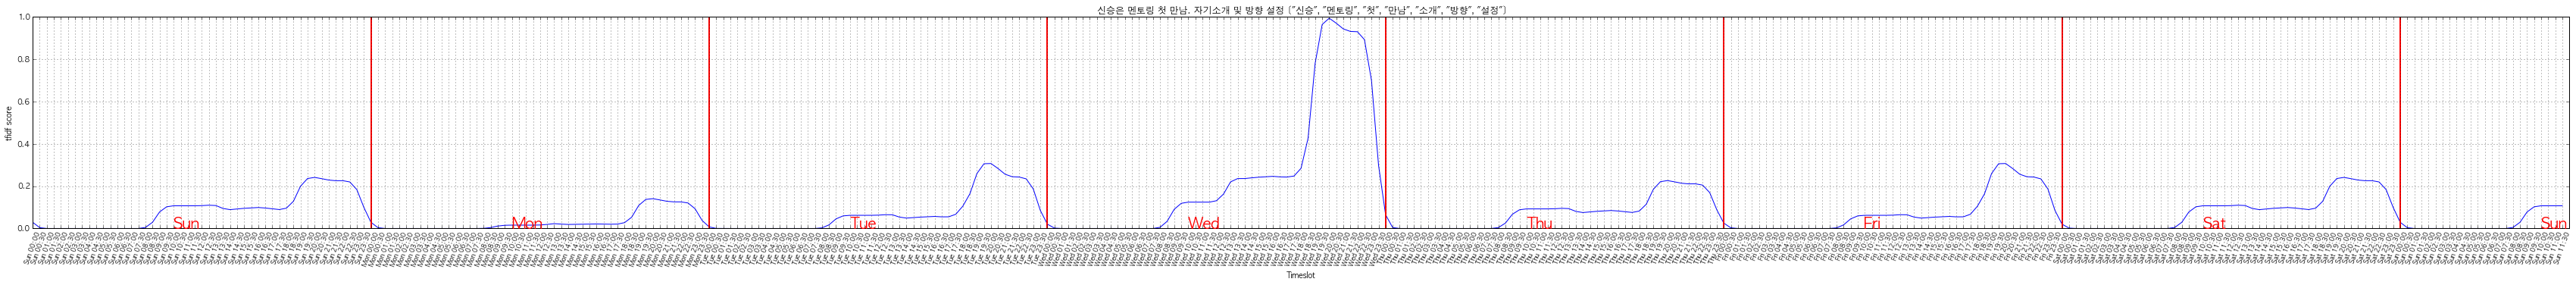

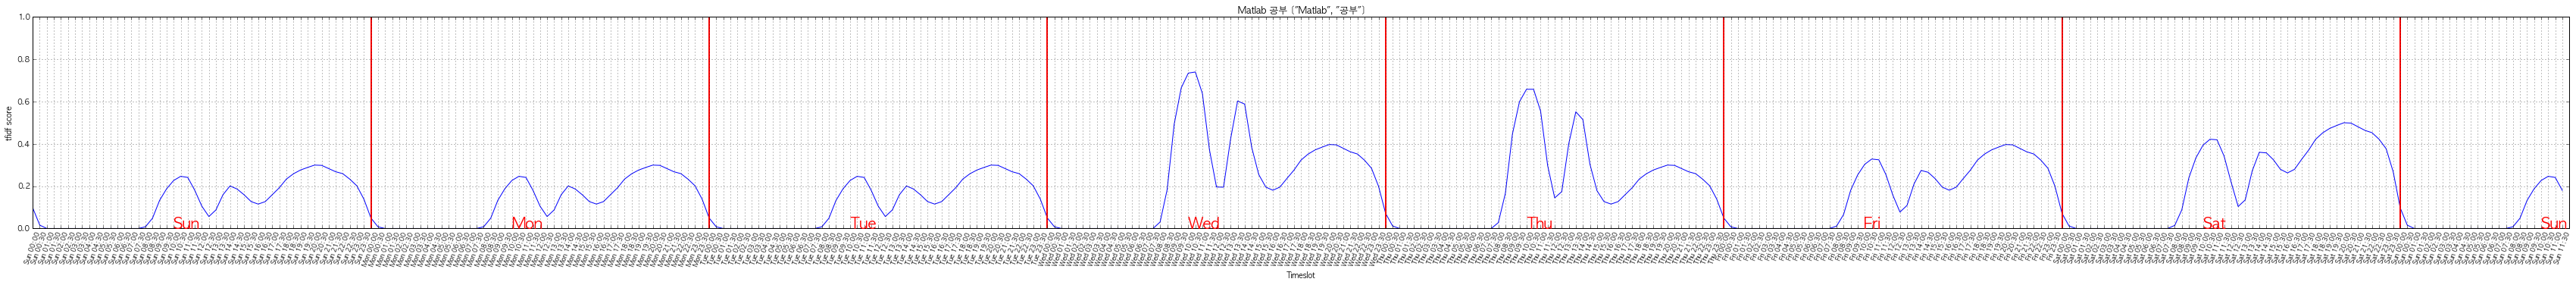

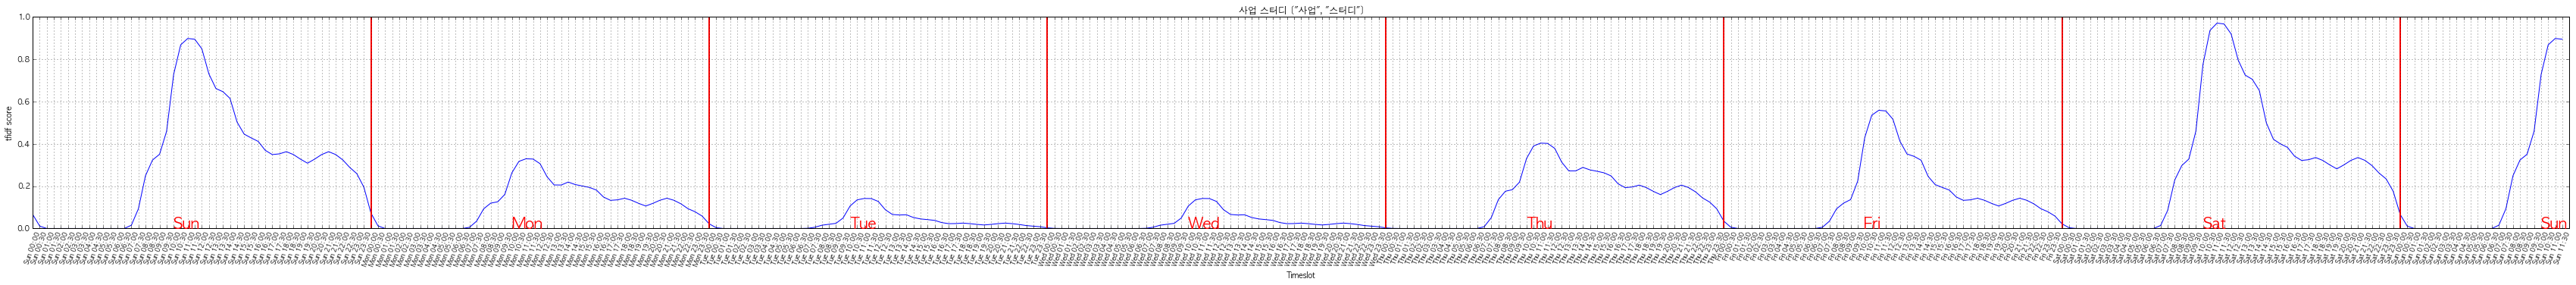

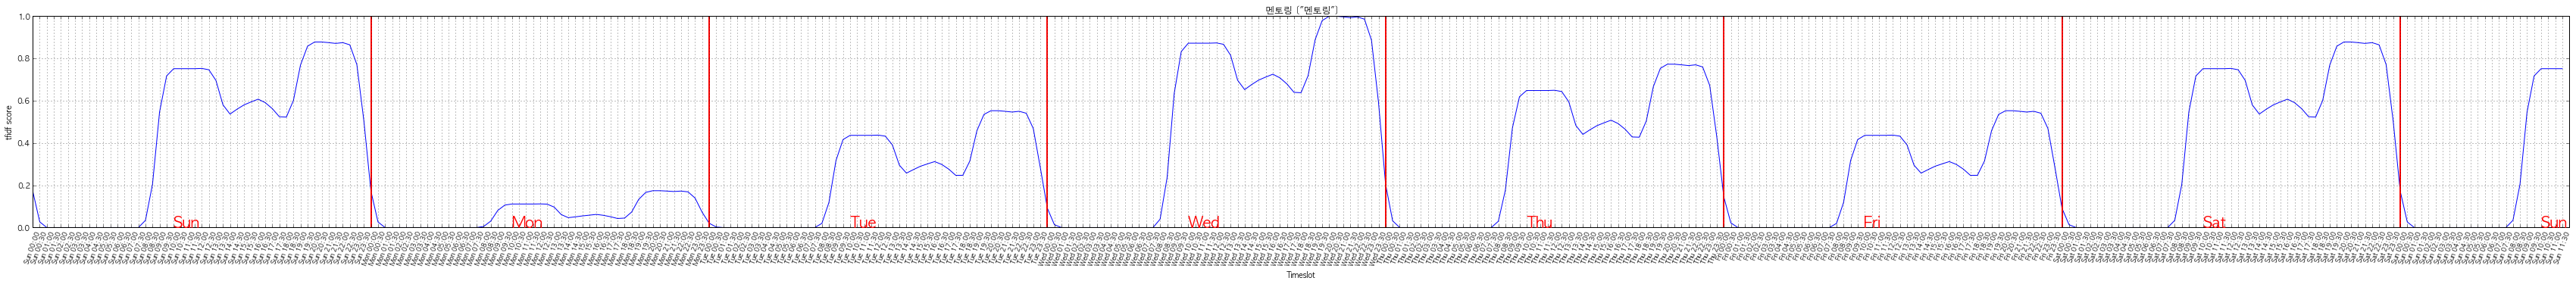

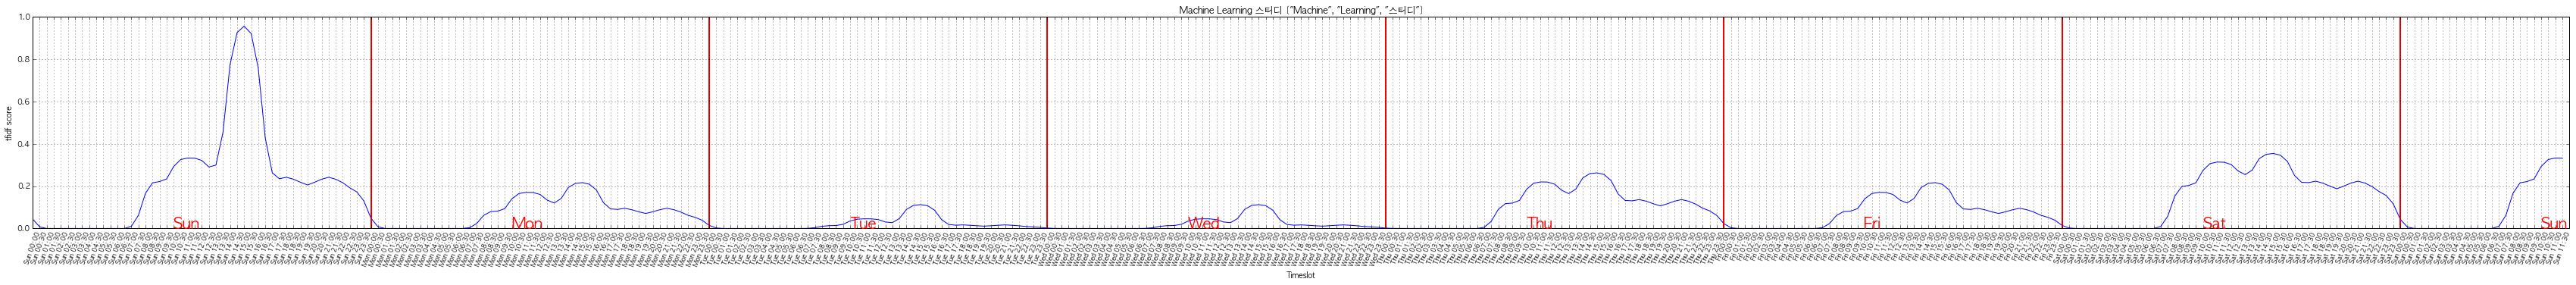

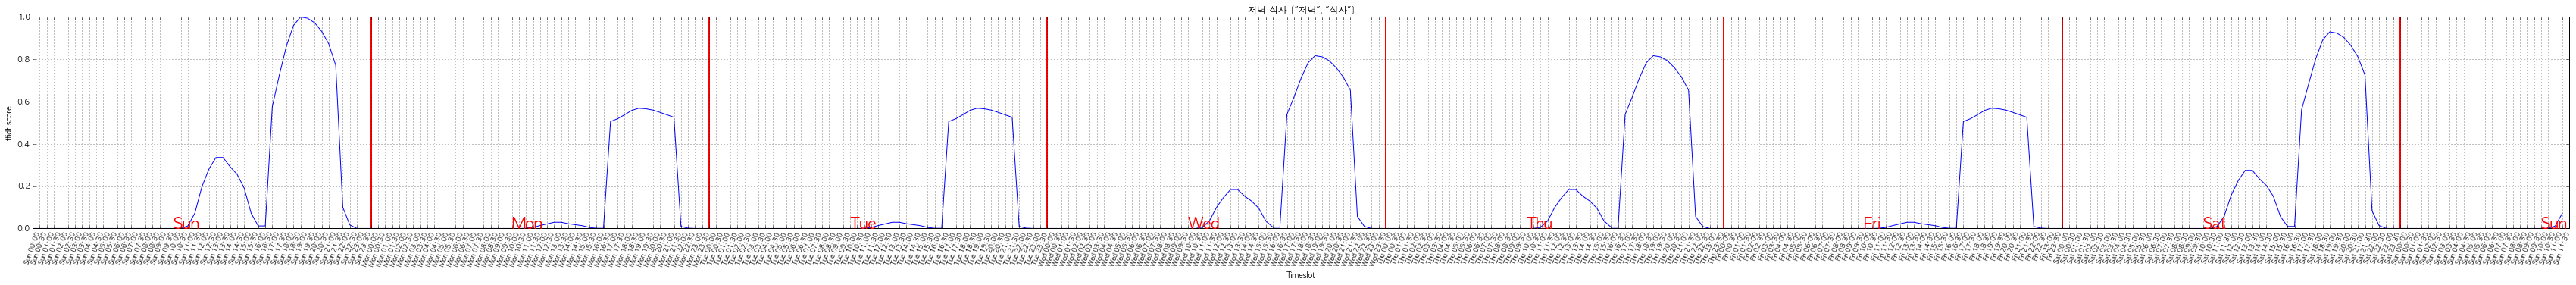

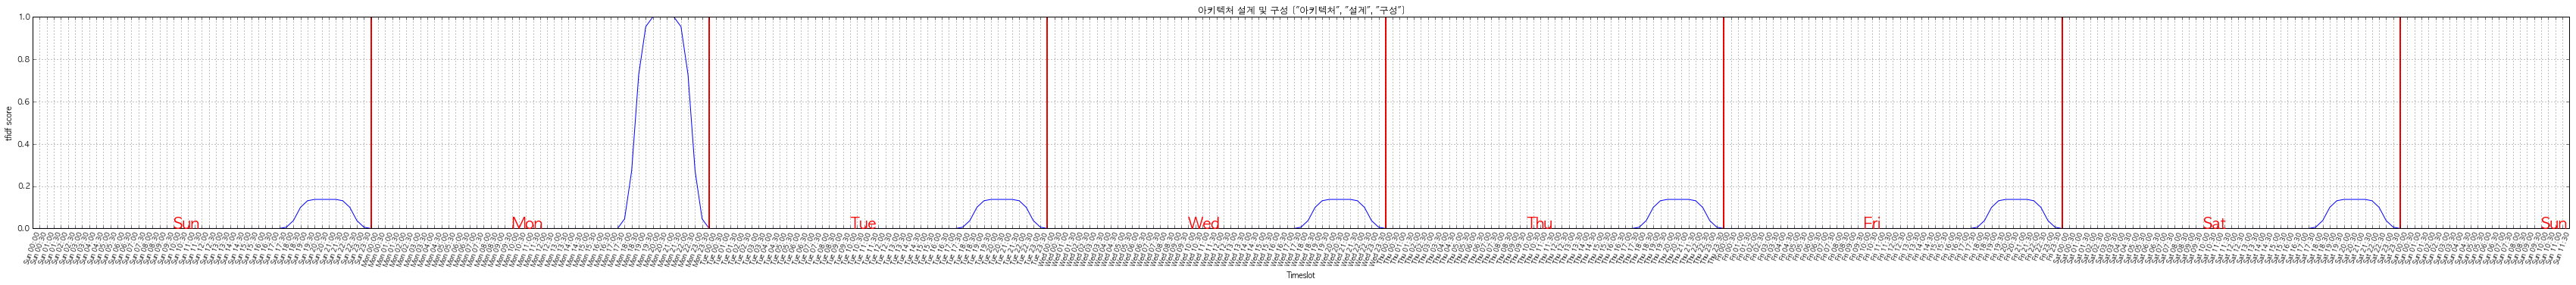

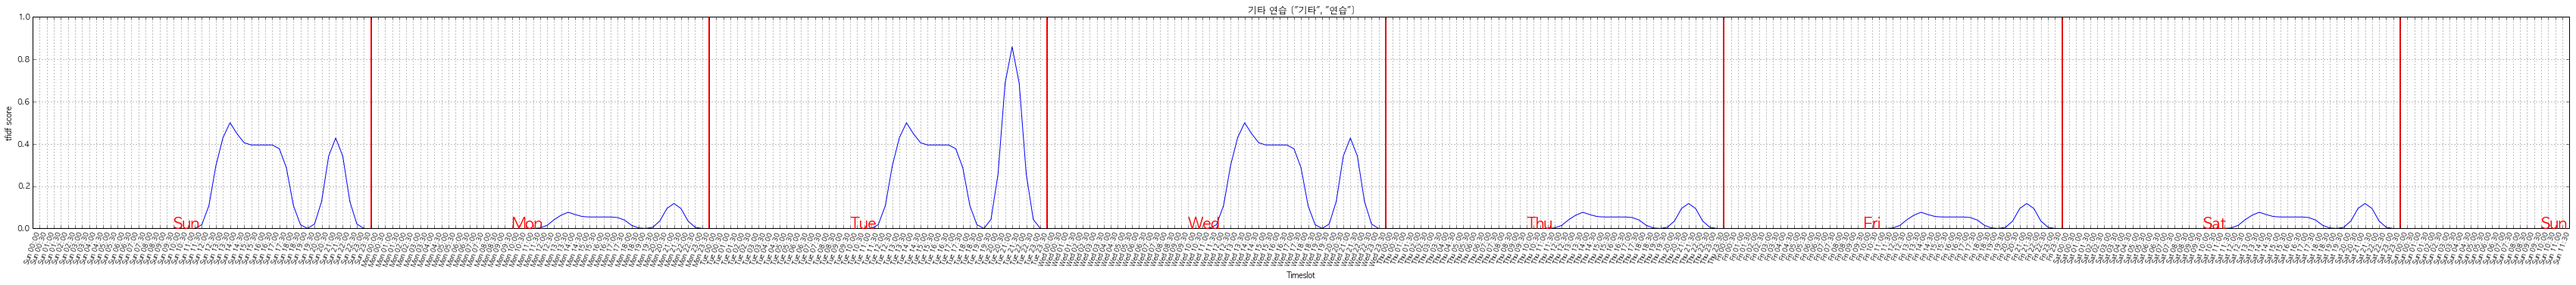

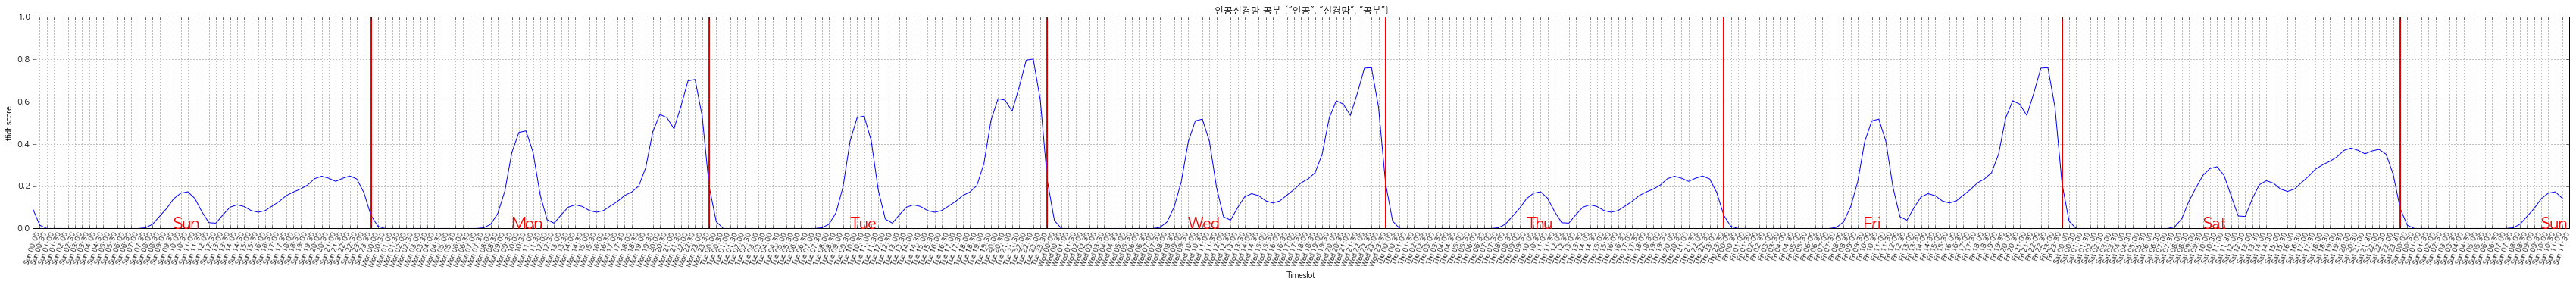

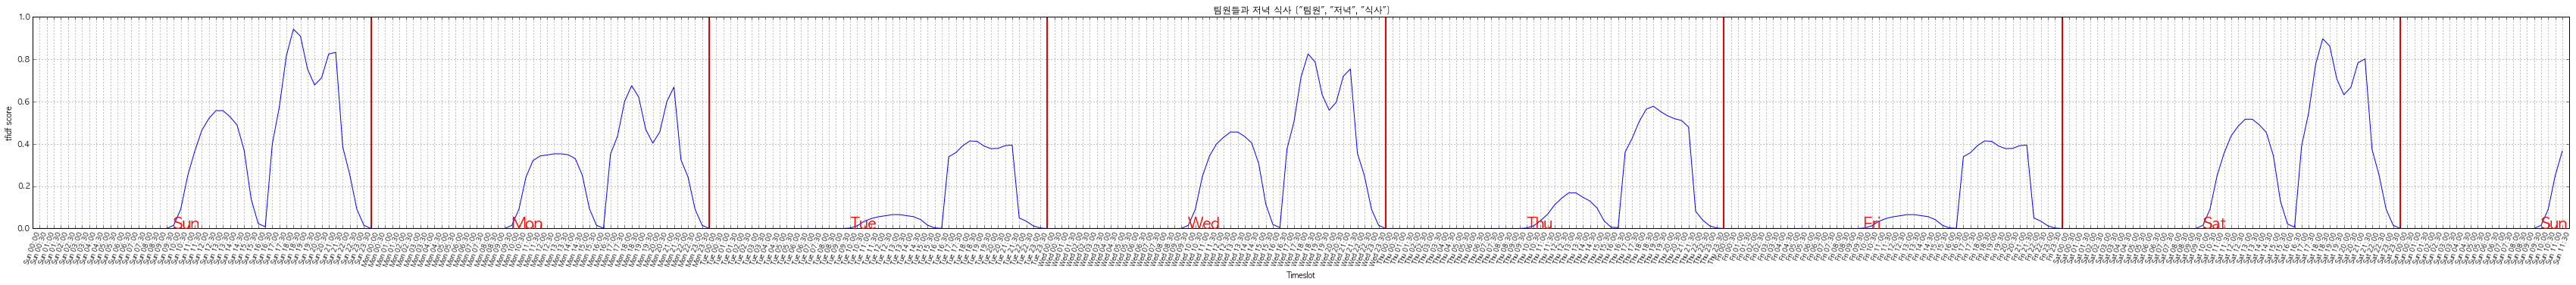

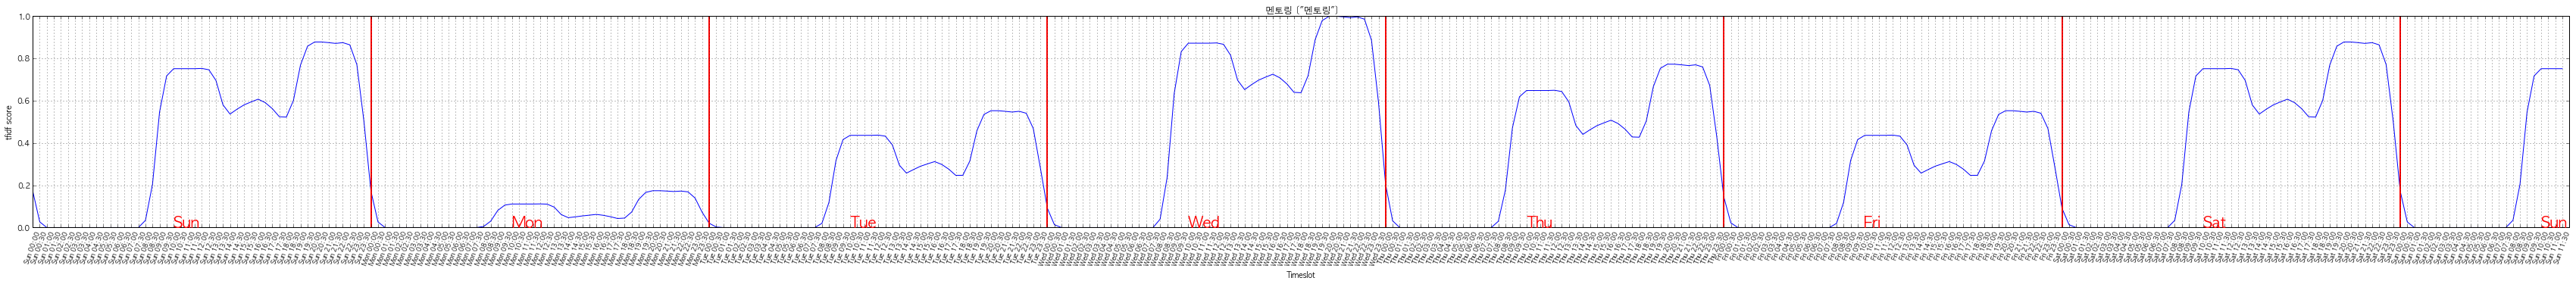

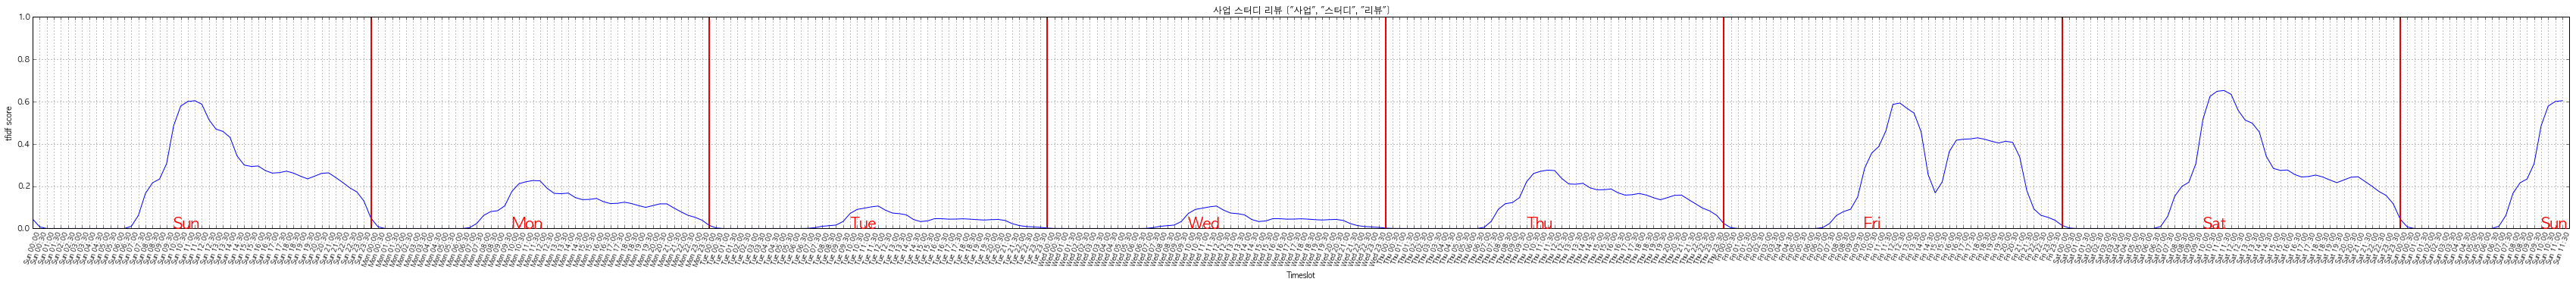

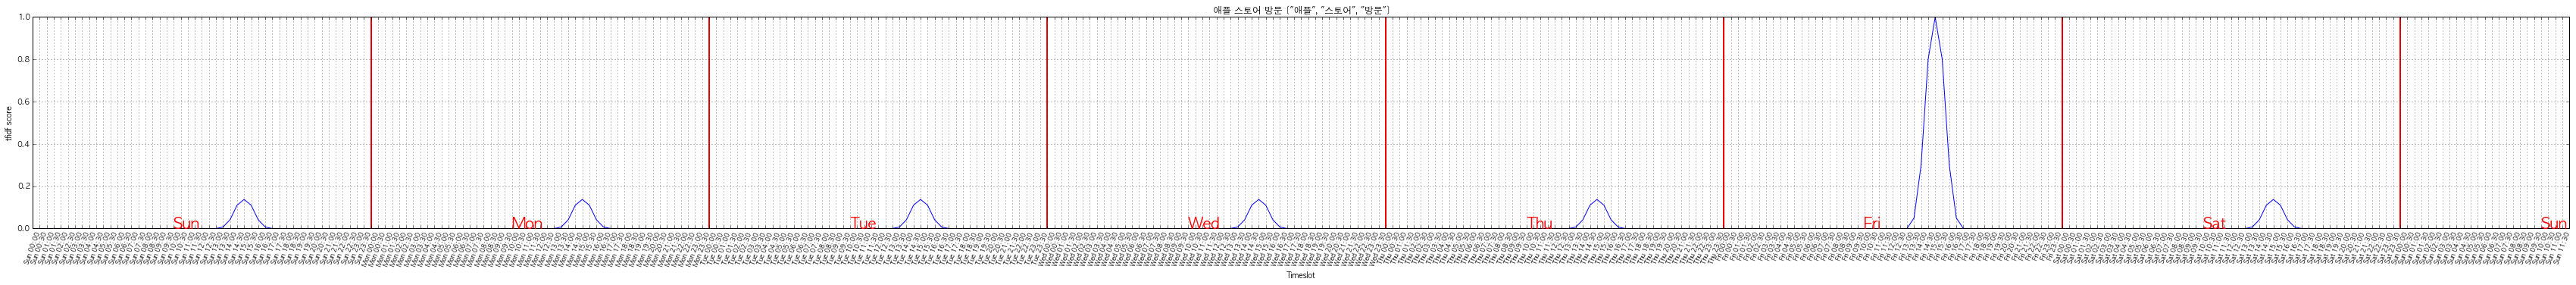

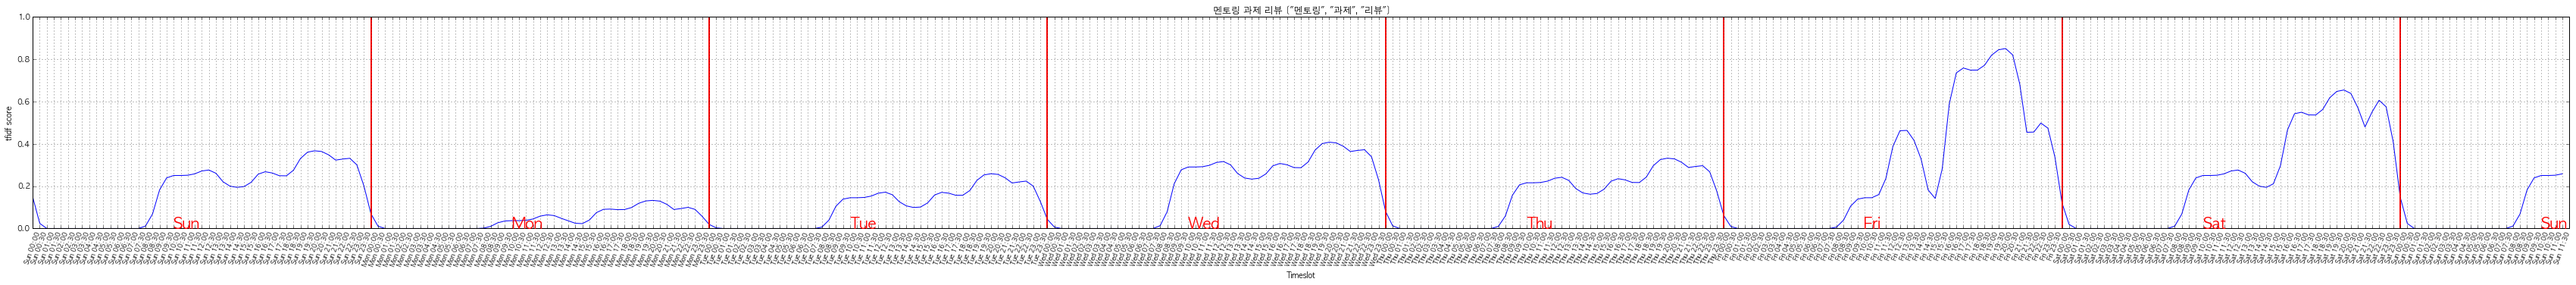

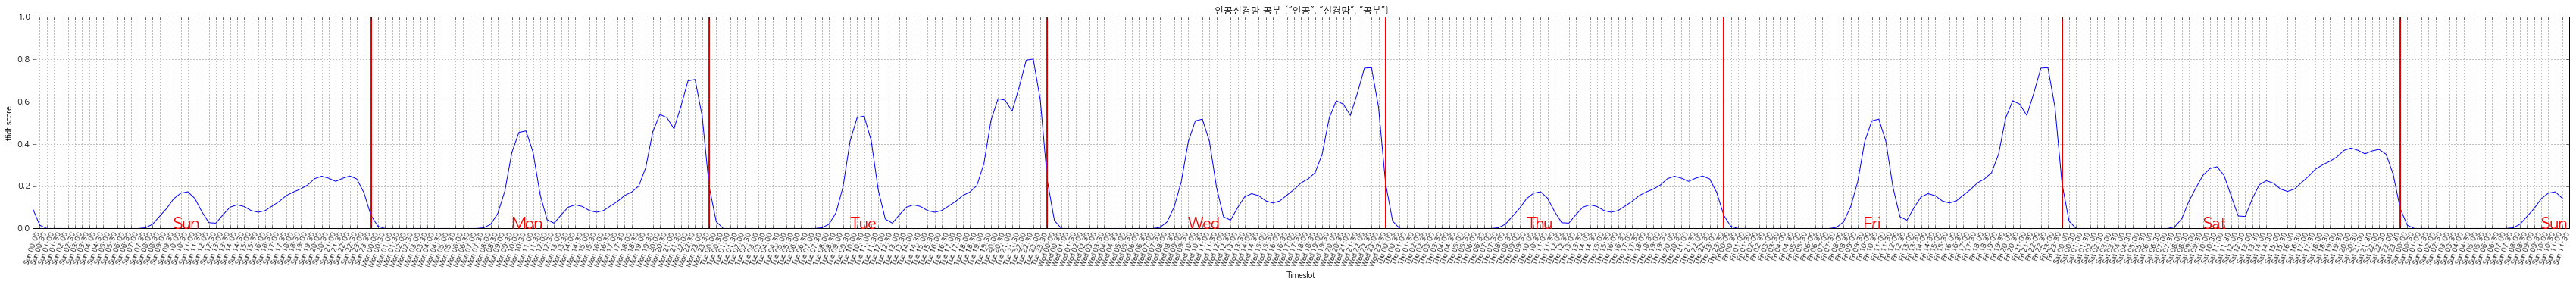

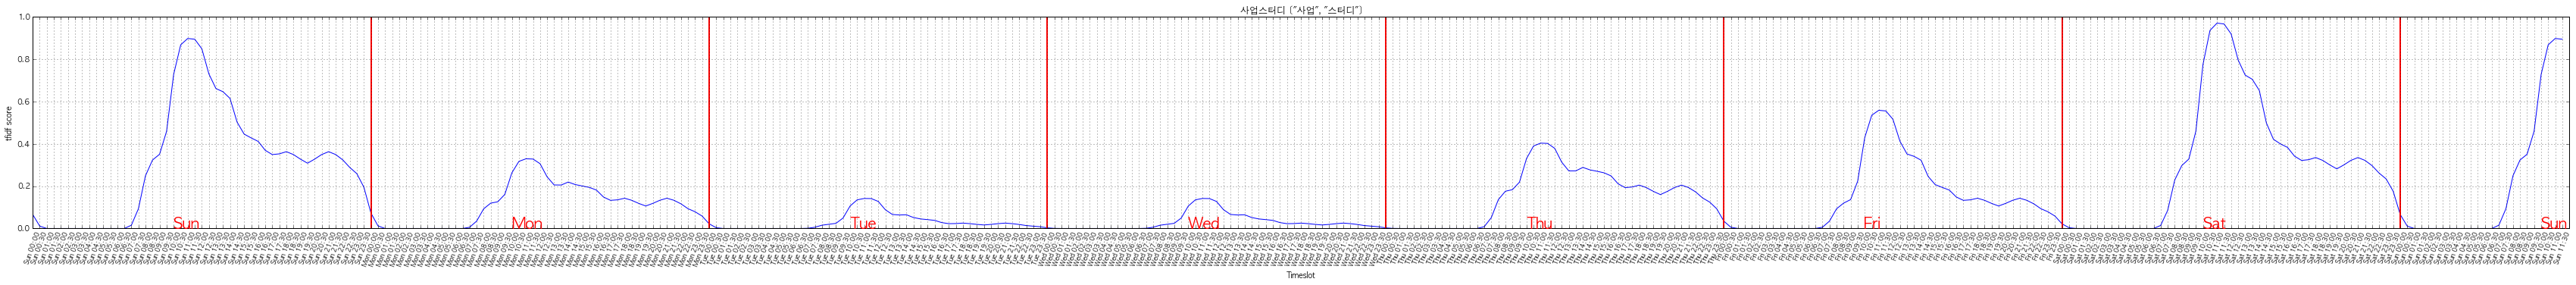

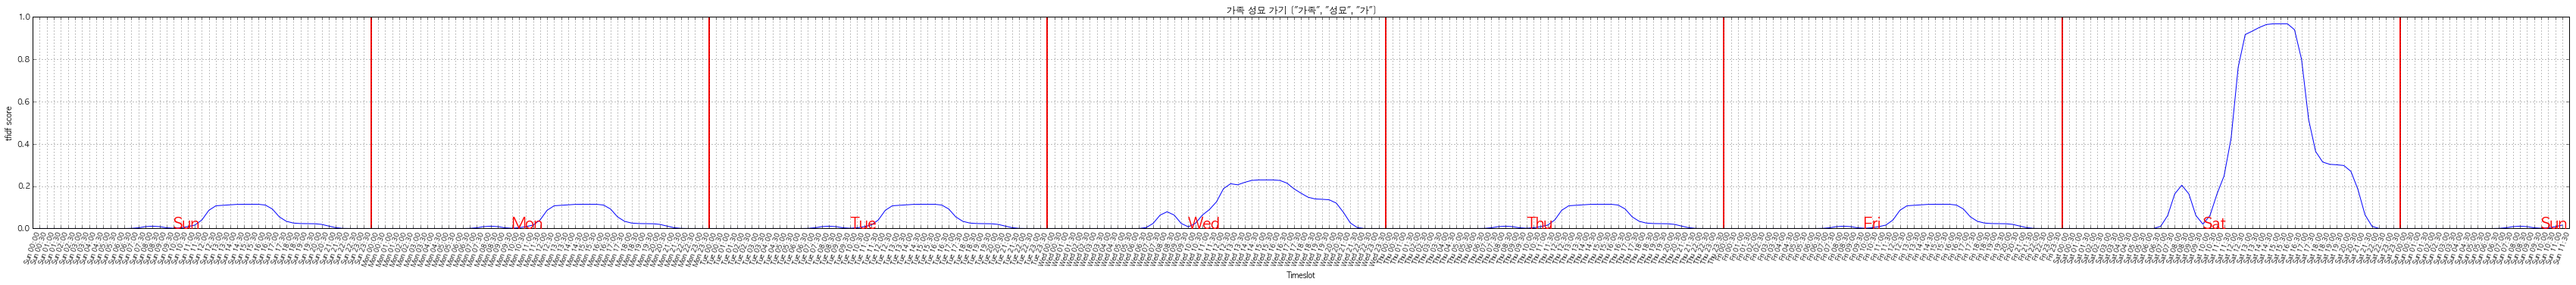

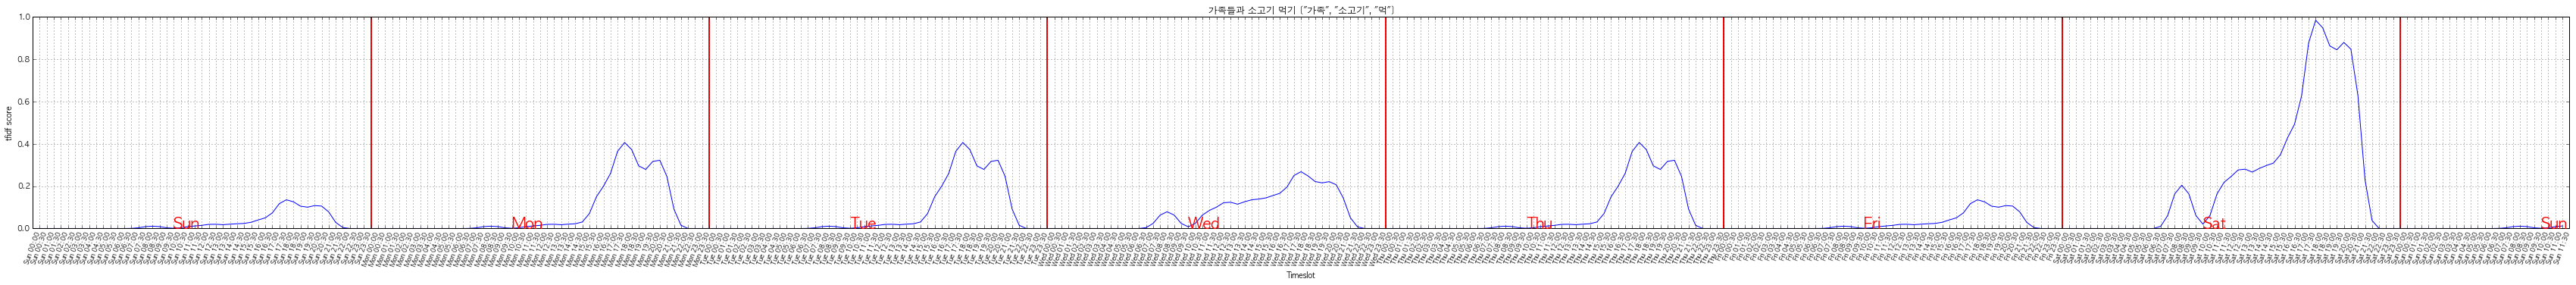

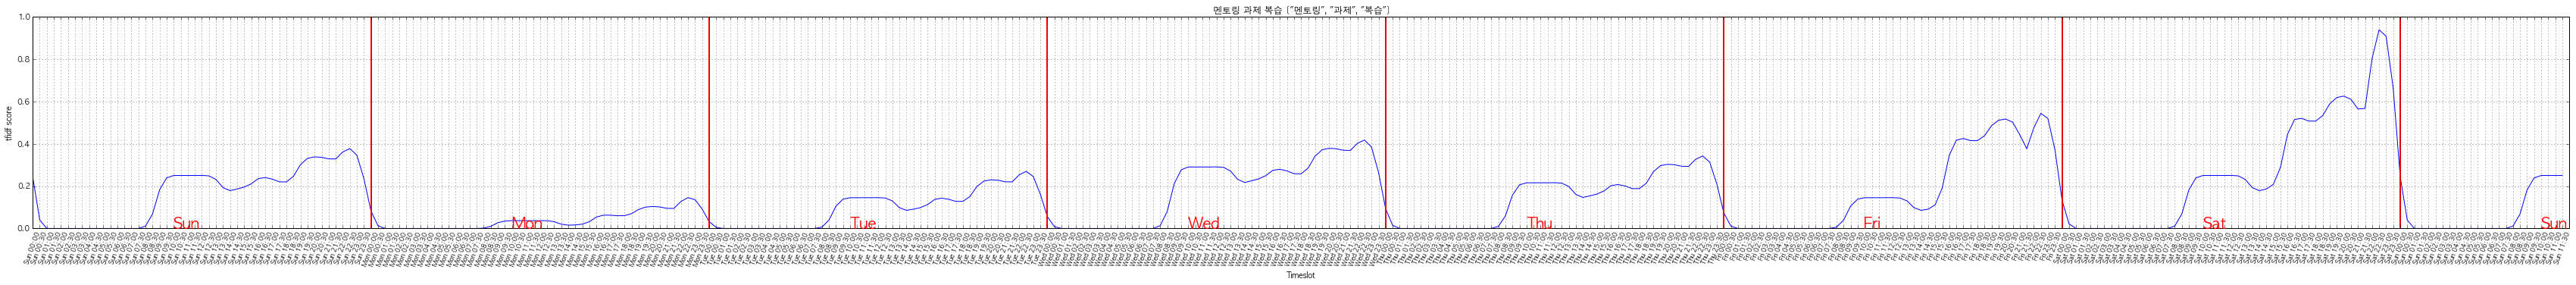

KeyboardInterrupt: 

In [15]:
# TEST Script
%matplotlib inline

from pymongo import MongoClient
import batchTimePrefScore as calc
reload(calc)
import tokenizer

import sys
reload(sys) # Encoding trick. Suppress encoding error when we pass Korean as sys.argv
sys.setdefaultencoding("utf-8")


# db_addr='128.199.166.149'
db_addr='localhost'
db_port=27340

client = MongoClient(db_addr, db_port)
# print client.database_names()
db = client.test
# print db.collection_names()

collection = db.predicttokens;

timelabel=[]
weekday_name = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
for i in range(48*7):
    timelabel.append('%s %02d:%02d'%(weekday_name[i/48],(i%48)/2, i%2*30))

total_num = len(cal.vevent_list);
num = 0;
for event in cal.vevent_list:
    num += 1
    if num % 10 == 0:
        print '%d / %d'%(num, total_num)
    
    content = event.summary.value + ' ' + event.description.value
    tokens = tokenizer.extractor(content)

    score = calc.getTimePrefScore(userID, collection, tokens)

    import json

    f = visualize(content,json.dumps(tokens, ensure_ascii=False).encode('utf-8'), score, timelabel)
    f.savefig('image_log/'+event.summary.value+'.png', dpi=100)
